## Integrantes

Nombre: Mathias Alexis Tello Moyano

Email: mtellom@correo.uss.cl

Rut: 21013401-8

## Celda 1: Imports y configuración básica
Carga todas las librerías necesarias para el flujo de trabajo:

- pandas, numpy: manejo y procesamiento de datos.
- joblib: guardar y cargar modelos entrenados.
- scikit-learn: provee imputación, normalización, modelos de ML, validación cruzada, métricas, etc.
- warnings: control de advertencias.

Variables principales:
- RANDOM_STATE: semilla aleatoria para reproducibilidad.
- SAMPLE: número de filas que se leerán del dataset (permite trabajar con subconjuntos).
- N_ITER: número de iteraciones de búsqueda aleatoria en RandomizedSearchCV.

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.isotonic import IsotonicRegression
from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import warnings

RANDOM_STATE = 1273
SAMPLE = 20000 # si quiere trabajar con un subconjunto para pruebas ponemos por ejemplo 20000

# Parámetros de ejecución
N_ITER = 25 # iteraciones para RandomizedSearchCV

ERROR! Session/line number was not unique in database. History logging moved to new session 4


## Celda 2: Cargar datos

Lee el archivo `habits_data_10e5.csv\
Si SAMPLE no es None, carga solo las primeras nrows para pruebas rápidas.\
Muestra forma (shape) y nombres de columnas.\
Devuelve las primeras filas para inspección visual.

Esto es hecho para checkear estructura del dataset antes del modelado y para debugging.

In [2]:
path = 'habits_data_10e5.csv'
if SAMPLE is None:
    df = pd.read_csv(path, index_col=0)
else:
    df = pd.read_csv(path, index_col=0, nrows=SAMPLE)

print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

df.head()

Shape: (20000, 26)
Columns: ['age', 'height', 'weight', 'waistline', 'sight_left', 'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'sex', 'SMK_type_1', 'SMK_type_2', 'SMK_type_3', 'DRK']


,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,...,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,sex,SMK_type_1,SMK_type_2,SMK_type_3,DRK
0,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,80.0,...,1.0,1.0,21.0,35.0,40.0,False,True,False,False,False
1,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,82.0,...,1.0,0.9,20.0,36.0,27.0,False,False,False,True,True
2,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,70.0,...,1.0,0.9,47.0,32.0,68.0,False,True,False,False,True
3,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,87.0,...,1.0,1.1,29.0,34.0,18.0,False,True,False,False,True
4,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,82.0,...,1.0,0.8,19.0,12.0,25.0,False,True,False,False,True


## Celda 3: Preparar X, y

Define las variables predictoras (X) y la variable objetivo (y).\
Toma la última columna como variable objetivo. En este caso es la columna DRK en el dataset.\
Aplica imputación de valores faltantes usando la mediana, que funciona para valores atípicos.
Divide en conjuntos train/test (70/30) de forma estratificada, para mantener la proporción de clases en ambos subconjuntos.

In [3]:
target_col = df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Imputación simple por mediana (para outliers)
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# División train/test (70/30) preserva proporciones
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (14000, 25) Test shape: (6000, 25)


## Celda 4: Definir modelos y espacios de búsqueda

Define los modelos base y los hiperparámetros que se explorarán con RandomizedSearchCV, siendo estos:
- LogisticRegression
- RandomForestClassifier
- GradientBoostingClassifier

Espacios de búsqueda (param_distributions): rangos de valores para cada modelo.
- LogisticRegression: C y penalty.
- RandomForestClassifier: n_estimators, max_depth y max_features.
- GradientBoostingClassifier: n_estimators, learning_rate y max_depth.

También se define validación cruzada estratificada (5 folds).

Función `search_and_eval`:
1. Crea un pipeline (probamos con y sin normalización).
2. Ejecuta búsqueda aleatoria de hiperparámetros.
3. Retorna el mejor modelo y el AUC en test.

In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models = {
'logistic': LogisticRegression(solver='saga', max_iter=2000, random_state=RANDOM_STATE),
'rf': RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
'gb': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

param_distributions = {
'logistic': {'clf__C': np.logspace(-4,4,30), 'clf__penalty': ['l1','l2']},
'rf': {'clf__n_estimators': [50,100,200], 'clf__max_depth': [None,5,10,20], 'clf__max_features':['sqrt','log2',0.5]},
'gb': {'clf__n_estimators': [50,100,200], 'clf__learning_rate':[0.01,0.05,0.1], 'clf__max_depth':[3,5,8]}
}

# Función para búsqueda y evaluación
def search_and_eval(estimator, param_dist, X_tr, y_tr, X_te, y_te, n_iter=N_ITER, normalize=False):
    steps = []
    if normalize:
        steps.append(('norm', Normalizer())) # normalización por muestra (no estandarización)
    steps.append(('clf', estimator))
    pipe = Pipeline(steps)
    rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=n_iter, scoring='roc_auc', cv=cv, random_state=RANDOM_STATE, n_jobs=-1)
    rs.fit(X_tr, y_tr)
    best = rs.best_estimator_
    y_pred = best.predict_proba(X_te)[:,1]
    return rs, roc_auc_score(y_te, y_pred)

## Celda 5: Ejecutar búsquedas

Ejecuta el entrenamiento y búsqueda de hiperparámetros para los tres modelos. (También desactiva advertencias de convergencia, para que el log esté limpio)

Para cada modelo, realiza dos búsquedas:
- Sin normalización.
- Con normalización.

Guarda resultados en diccionario `results` con:
- Mejor estimador.
- AUC con y sin normalización.
- Mejores parámetros encontrados.

Los resultados finales usando SAMPLE=20000, RANDOM_STATE=1273 y N_ITER=25 son:
```
logistic AUC no norm: 0.7873 AUC norm: 0.7976
rf AUC no norm: 0.8086 AUC norm: 0.8059
gb AUC no norm: 0.813 AUC norm: 0.8126
```

Hay varias conclusiones por las cuales podemos rescatar:
- El modelo de Gradient Boosting (GB) obtuvo el mejor AUC, tanto con como sin normalización.
- La normalización mejoró ligeramente el rendimiento del modelo logístico, pero tuvo un efecto menor en los modelos de árbol (RF y GB).
- El tiempo de entrenamiento fue considerablemente mayor para los modelos de árbol, especialmente GB, debido a la complejidad del modelo y la búsqueda de hiperparámetros.

Los datos sugieren que el modelo GB es el más adecuado para este conjunto de datos, y la normalización puede ser beneficiosa para modelos lineales como la regresión logística. Sin embargo, normalizar los modelos de árbol no aporta mejoras significativas en este caso o de inclusive puede que ligeramente reduzca el rendimiento. El modelo logístico podría ser una opción viable si se prioriza la interpretabilidad y velocidad/recursos de entrenamiento sobre el rendimiento puro.

In [6]:
from sklearn.exceptions import ConvergenceWarning

results = {}
warnings.filterwarnings("ignore", category=ConvergenceWarning)

i = 0
for name, est in models.items():
    i += 1
    print(f'[{i}/{len(models)}] Procesando modelo: {name}')
    rs, auc_no_norm = search_and_eval(est, param_distributions[name], X_train, y_train, X_test, y_test, n_iter=N_ITER, normalize=False)
    rsn, auc_norm = search_and_eval(est, param_distributions[name], X_train, y_train, X_test, y_test, n_iter=N_ITER, normalize=True)
    results[name] = {
    'rs_object': rs,
    'auc_no_norm': auc_no_norm,
    'best_params_no_norm': rs.best_params_,
    'rs_norm': rsn,
    'auc_norm': auc_norm,
    'best_params_norm': rsn.best_params_
    }

print("------ OK ------")
# Mostrar AUCs
for k,v in results.items():
    print(k, 'AUC no norm:', round(v['auc_no_norm'],4), 'AUC norm:', round(v['auc_norm'],4))

[1/3] Procesando modelo: logistic
[2/3] Procesando modelo: rf
[3/3] Procesando modelo: gb
------ OK ------
logistic AUC no norm: 0.7873 AUC norm: 0.7976
rf AUC no norm: 0.8086 AUC norm: 0.8059
gb AUC no norm: 0.813 AUC norm: 0.8126


## Celda 6: Selección por importancia de variables

Entrena un RandomForestClassifier sobre los datos de entrenamiento para estimar importancia de variables.\
Ordena las variables por importancia decreciente.\
Muestra las 25 más relevantes.\
Guarda las 10 principales (top10) para futuras pruebas.

Aquí es para reducir dimensionalidad y comparar en la siguiente celda si un subconjunto pequeño de variables mantiene el rendimiento.

In [8]:
rf_for_fs = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE)
rf_for_fs.fit(X_train, y_train)
importances = pd.Series(rf_for_fs.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print('Top 25 features:\n', importances)

top10 = importances.head(10).index.tolist()
print('Top 10 features:', top10)

Top 25 features:
 gamma_GTP           0.076345
age                 0.066555
hemoglobin          0.066023
HDL_chole           0.062392
triglyceride        0.054497
height              0.053325
LDL_chole           0.050628
tot_chole           0.050422
sex                 0.050191
BLDS                0.049031
SGOT_ALT            0.048337
waistline           0.048080
SBP                 0.045209
DBP                 0.043705
SGOT_AST            0.042896
SMK_type_1          0.038074
weight              0.035834
serum_creatinine    0.031176
sight_right         0.030602
sight_left          0.029941
SMK_type_3          0.012091
SMK_type_2          0.006270
urine_protein       0.004506
hear_right          0.002226
hear_left           0.001645
dtype: float64
Top 10 features: ['gamma_GTP', 'age', 'hemoglobin', 'HDL_chole', 'triglyceride', 'height', 'LDL_chole', 'tot_chole', 'sex', 'BLDS']


## Celda 7: Reentrenar modelos con top10

Usa las 10 variables más importantes para reentrenar y evaluar nuevamente los modelos.\
Clona el mejor estimador de cada modelo (sin normalizar).\
Entrena sobre las 10 variables.\
Evalúa AUC con y sin normalización.\
Guarda los resultados en results_top10.

Los resultados finales usando SAMPLE=20000, RANDOM_STATE=1273 y N_ITER=25 son:
```
logistic AUC top10: 0.7677 AUC top10 norm: 0.781
rf AUC top10: 0.7954 AUC top10 norm: 0.7931
gb AUC top10: 0.7991 AUC top10 norm: 0.7962
```

Naturalmente, los resultados usando solo el top 10 features son inferiores a los obtenidos usando todas las variables. Sin embargo, la reducción de dimensionalidad puede ser beneficiosa en términos de interpretabilidad y eficiencia computacional, en especial para modelos más simples como la regresión logística. Aunque el rendimiento disminuye, los modelos siguen siendo razonablemente efectivos, especialmente considerando la reducción significativa en el número de variables. Esto sugiere que las 10 variables seleccionadas capturan gran parte de la información relevante para la predicción, aunque no toda. Algo más a notar es que no normalizar el modelo logístico con el top 10 features resulta en una caída bastante más pronunciada del AUC comparado con el modelo completo, que nos indica que la normalización es más crítica cuando se trabaja con un conjunto reducido de variables.

In [9]:
results_top10 = {}
for name, rs in results.items():
    # usar el estimador entrenado encontrado sin normalización
    best_pipe = rs['rs_object'].best_estimator_

    # extraer classifier y reentrenar sobre top10
    pipe_steps = []
    if 'norm' in best_pipe.named_steps:
        pipe_steps.append(('norm', best_pipe.named_steps['norm']))
    pipe_steps.append(('clf', best_pipe.named_steps['clf']))

    clf = best_pipe.named_steps['clf']
    clf_clone = clone(clf)
    clf_clone.fit(X_train[top10], y_train)
    auc_top10 = roc_auc_score(y_test, clf_clone.predict_proba(X_test[top10])[:,1])

    # with normalization
    norm = Normalizer().fit(X_train[top10])
    clf_norm = clone(clf)
    clf_norm.fit(norm.transform(X_train[top10]), y_train)
    auc_top10_norm = roc_auc_score(y_test, clf_norm.predict_proba(norm.transform(X_test[top10]))[:,1])

    results_top10[name] = {'auc_top10': auc_top10, 'auc_top10_norm': auc_top10_norm}


for k,v in results_top10.items():
    print(k, 'AUC top10:', round(v['auc_top10'],4), 'AUC top10 norm:', round(v['auc_top10_norm'],4))

logistic AUC top10: 0.7677 AUC top10 norm: 0.781
rf AUC top10: 0.7954 AUC top10 norm: 0.7931
gb AUC top10: 0.7991 AUC top10 norm: 0.7962


## Celda 8: Guardar el mejor modelo

Selecciona el modelo con mayor AUC sin normalización y lo guarda en disco usando joblib.dump().\
Esto nos retorna un archivo best_model_pipeline.joblib con el pipeline completo.

In [10]:
best_name = max(results.keys(), key=lambda k: results[k]['auc_no_norm'])
best_model = results[best_name]['rs_object'].best_estimator_
joblib.dump(best_model, 'best_model_pipeline.joblib')
print('Mejor modelo guardado:', best_name)

Mejor modelo guardado: gb


## Celda 9: Recomendador con reglas de asignación y equidad

Implementa un sistema de recomendación que asigna programas o niveles de riesgo en función de las probabilidades predichas.
Incluye:
- Calibración de probabilidades usando IsotonicRegression.
- Reglas de asignación:
    - p ≥ 0.80: intensivo.
    - p ≥ 0.60: moderado.
    - p ≥ 0.40: monitoreo.
    - p < 0.40: bajo riesgo.

La función recommend_batch():
- Predice probabilidades y aplica las reglas.
- Permite incluir:
    - capacity: número máximo de plazas disponibles.
    - equity_constraints: restricciones de equidad por grupo (por ejemplo, género).
- Devuelve un DataFrame con probabilidad, programa, prioridad y selección final.

In [12]:
model_path = 'best_model_pipeline.joblib'   # o 'model_logistic.joblib', etc.
pipeline = joblib.load(model_path)


def calibrate_probabilities(clf_pipeline, X_val, y_val):
    probs = clf_pipeline.predict_proba(X_val)[:,1]
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(probs, y_val)
    return iso  # aplicar iso.predict(probs) cuando necesite prob calibrada

def assign_program(p):
    if p >= 0.80:
        return {'program': 'intensivo', 'priority': 3}
    elif p >= 0.60:
        return {'program': 'moderado', 'priority': 2}
    elif p >= 0.40:
        return {'program': 'monitoreo', 'priority': 1}
    else:
        return {'program': 'bajo riesgo', 'priority': 0}

def recommend_batch(X, pipeline, calibrator=None,
                    capacity=None,  # capacidad total de plazas (int) o None
                    equity_constraints=None  # dict, ej: {'gender': {'M':0.6,'F':0.4}}
                   ):
    X = X.copy()
    probs = pipeline.predict_proba(X)[:,1]
    if calibrator is not None:
        probs = calibrator.predict(probs)
    X['prob'] = probs
    X['program'] = X['prob'].apply(lambda p: assign_program(p)['program'])
    X['priority'] = X['prob'].apply(lambda p: assign_program(p)['priority'])

    X['selected'] = False
    if capacity is None:
        X['selected'] = X['priority']>0  # o criterio operativo
        return X

    # Selección con capacidad y reglas de equidad
    selected_indices = []
    remaining = capacity

    if equity_constraints is None:
        # simple top-K by probability
        selected_indices = X.head(capacity).index.tolist()
    else:
        # equity_constraints: {'gender': {'M':0.6,'F':0.4}}
        # implementamos a nivel por cada constraint independently (simple)
        # prioridad: asignar por grupos según cuota sobre capacity
        quotas = {}
        for col, dist in equity_constraints.items():
            quotas[col] = {grp: int(np.floor(frac*capacity)) for grp,frac in dist.items()}

        # Iterar por filas y asignar si grupo aún tiene cuota o general slots remaining
        per_group_count = { (col,grp):0 for col in equity_constraints for grp in equity_constraints[col] }
        for idx, row in X.iterrows():
            if remaining<=0:
                break
            accept = True
            for col, dist in equity_constraints.items():
                grp = row.get(col)
                if grp in dist:
                    cap_for_grp = quotas[col][grp]
                    current = per_group_count[(col,grp)]
                    if current >= cap_for_grp:
                        accept = False
                        break
            if accept:
                selected_indices.append(idx)
                remaining -= 1
                for col in equity_constraints:
                    grp = row.get(col)
                    if grp in equity_constraints[col]:
                        per_group_count[(col,grp)] += 1
        # Si quedan slots, llenar sin restricciones
        if remaining>0:
            for idx in X.index:
                if idx in selected_indices:
                    continue
                selected_indices.append(idx)
                remaining -= 1
                if remaining==0:
                    break

    X.loc[selected_indices, 'selected'] = True
    return X


## Celda 10: Generar datos sintéticos
Crea un dataset sintético de ejemplo (nuevo_batch.csv) con valores clínicos.\
Para esto define una lista de columnas clínicas y usa funciones aleatorias con distribuciones apropiadas (normales o uniformes).\
Generamos 200 registros y guardamos en CSV.

In [81]:
columns = [
'age','height','weight','waistline','sight_left','sight_right','hear_left','hear_right',
'SBP','DBP','BLDS','tot_chole','HDL_chole','LDL_chole','triglyceride','hemoglobin',
'urine_protein','serum_creatinine','SGOT_AST','SGOT_ALT','gamma_GTP','sex',
'SMK_type_1','SMK_type_2','SMK_type_3'
]

# Generar 100 registros sintéticos con valores clínicos
def generar_valores(col):
    if col == 'age': return np.random.randint(20, 65)
    if col == 'height': return np.random.normal(170, 10)
    if col == 'weight': return np.random.normal(70, 15)
    if col == 'waistline': return np.random.normal(85, 10)
    if col in ['sight_left','sight_right']: return np.round(np.random.uniform(0.5, 1.5), 1)
    if col in ['hear_left','hear_right']: return 1.0
    if col in ['SBP']: return np.random.normal(125, 15)
    if col in ['DBP']: return np.random.normal(80, 10)
    if col in ['BLDS']: return np.random.normal(100, 15)
    if col in ['tot_chole','LDL_chole']: return np.random.normal(190, 30)
    if col in ['HDL_chole']: return np.random.normal(50, 10)
    if col in ['triglyceride']: return np.random.normal(120, 40)
    if col in ['hemoglobin']: return np.random.normal(15, 1.5)
    if col in ['urine_protein','serum_creatinine']: return np.round(np.random.uniform(0.8, 1.2), 1)
    if col in ['SGOT_AST','SGOT_ALT']: return np.random.normal(25, 10)
    if col == 'gamma_GTP': return np.random.normal(40, 20)
    if col == 'sex': return np.random.choice([True, False])
    if col.startswith('SMK_type_'): return np.random.choice([True, False])
    return np.nan

n = 200
data = {col: [generar_valores(col) for _ in range(n)] for col in columns}
df_new = pd.DataFrame(data)

# Guardar el archivo CSV para usar en la recomendación
df_new.to_csv('nuevo_batch.csv', index=False)
print('Archivo nuevo_batch.csv generado con 200 empleados de ejemplo y columnas')


Archivo nuevo_batch.csv generado con 100 empleados de ejemplo y columnas


## Celda 11: Correr recomendador de ejemplo

Carga el archivo nuevo_batch.csv y ejecuta el recomendador sobre los datos generados.\
Parámetros:
- capacity=200: máximo de individuos a recomendar.
- equity_constraints={'gender': {'M':0.6, 'F':0.4}}: garantiza proporción 60/40 entre hombres y mujeres.

Salida: tabla con probabilidad estimada y programa asignado a cada individuo.

In [61]:
df_new = pd.read_csv('nuevo_batch.csv')
recs = recommend_batch(df_new, pipeline, calibrator=None, capacity=200,
                       equity_constraints={'gender': {'M':0.6, 'F':0.4}})
recs[['prob','program']]

,prob,program,selected
0,0.352322,bajo riesgo,True
1,0.594465,monitoreo,True
2,0.229718,bajo riesgo,True
3,0.324701,bajo riesgo,True
4,0.897731,intensivo,True
5,0.458424,monitoreo,True
6,0.217203,bajo riesgo,True
7,0.268431,bajo riesgo,True
8,0.235476,bajo riesgo,True
9,0.439767,monitoreo,True


## Celda 12: Evaluar efectividad del recomendador

Prueba la efectividad con datos reales del dataset original. Aquí cargamos el dataset completo y usamos las últimas 1000 filas como muestra de validación donde:
- Aplica el recomendador y genera predicciones.\
- Compara predicciones (pred) con valores reales (real).\
- Calcula si cada predicción fue correcta (is_correct).

De forma preliminar, usando los parámetros por defecto, tenemos que el modelo logra una precisión del 73% en las últimas 1000 filas del dataset original. Esto indica que el modelo es capaz de predecir correctamente el estado objetivo en aproximadamente tres de cada cuatro casos, lo cual es un buen punto de partida. Sin embargo, hay margen para mejorar la precisión mediante ajustes adicionales en el modelo, calibración de probabilidades o refinamiento de las reglas de asignación. Sería útil analizar los casos incorrectos para entender mejor las limitaciones del modelo y buscar oportunidades de mejora.

In [13]:
# Seleccionar capacidad
capacidad = 1000

# Cargar datos originales
df_new = pd.read_csv("habits_data_10e5.csv")
# Guardar columna objetivo
y_true = df_new.iloc[:, -1]
# Eliminar primera y última columna
df_new = df_new.iloc[:, 1:-1]
# Separar las últimas 100 filas como datos de prueba (footer)
pred_footer = df_new.tail(capacidad)
y_footer = y_true.tail(capacidad)

recs = recommend_batch(pred_footer, pipeline, calibrator=None, capacity=capacidad,
                       equity_constraints={'gender': {'M':0.6, 'F':0.4}})

# Convertir probabilidad a predicción binaria
recs['pred'] = recs['prob'] >= 0.5
recs['real'] = y_footer.values
recs['is_correct'] = recs['pred'] == recs['real']

recs[['prob','program','pred','real', 'is_correct']]

,prob,program,pred,real,is_correct
99000,0.716764,moderado,True,True,True
99001,0.635097,moderado,True,True,True
99002,0.869797,intensivo,True,True,True
99003,0.580744,monitoreo,True,True,True
99004,0.475509,monitoreo,False,False,True
...,...,...,...,...,...
99995,0.308493,bajo riesgo,False,False,True
99996,0.324989,bajo riesgo,False,False,True
99997,0.228558,bajo riesgo,False,True,False
99998,0.189996,bajo riesgo,False,False,True


# Taller de Machine Learning ICIF1041

    • Prueba Solemne 2
    • Modalidad: grupos de 2 (puede ser individual)
    • Fecha de entrega: 7 Noviembre 2025 23:59

En esta prueba solemne, ustedes debe demostrar sus conocimientos adquiridos en la unidad 2. Cumplir con lo mínimo solicitado no le garantiza la nota máxima, ya que se espera pro actividad y curiosidad de su parte.

Usted cuenta con el apoyo de su profesor de laboratorio en caso de que requiera clarificar algún requerimiento o guía en esta tarea, por lo que si se ve estancado o no entiende alguna parte del proyecto, escriba un correo o pida una reunión con su profesor. En la clase de teoria de la semana del 7 de Noviembre se resolverán dudas y responderán preguntas  referentes a la prueba.

Se entrega el jupyter notebook. Use celdas con texto para justificar y explicar cada paso. Se esperan al menos 2000 palabras de justificación y explicación de los pasos seguidos y resultados obtenidos.

Rúbrica:

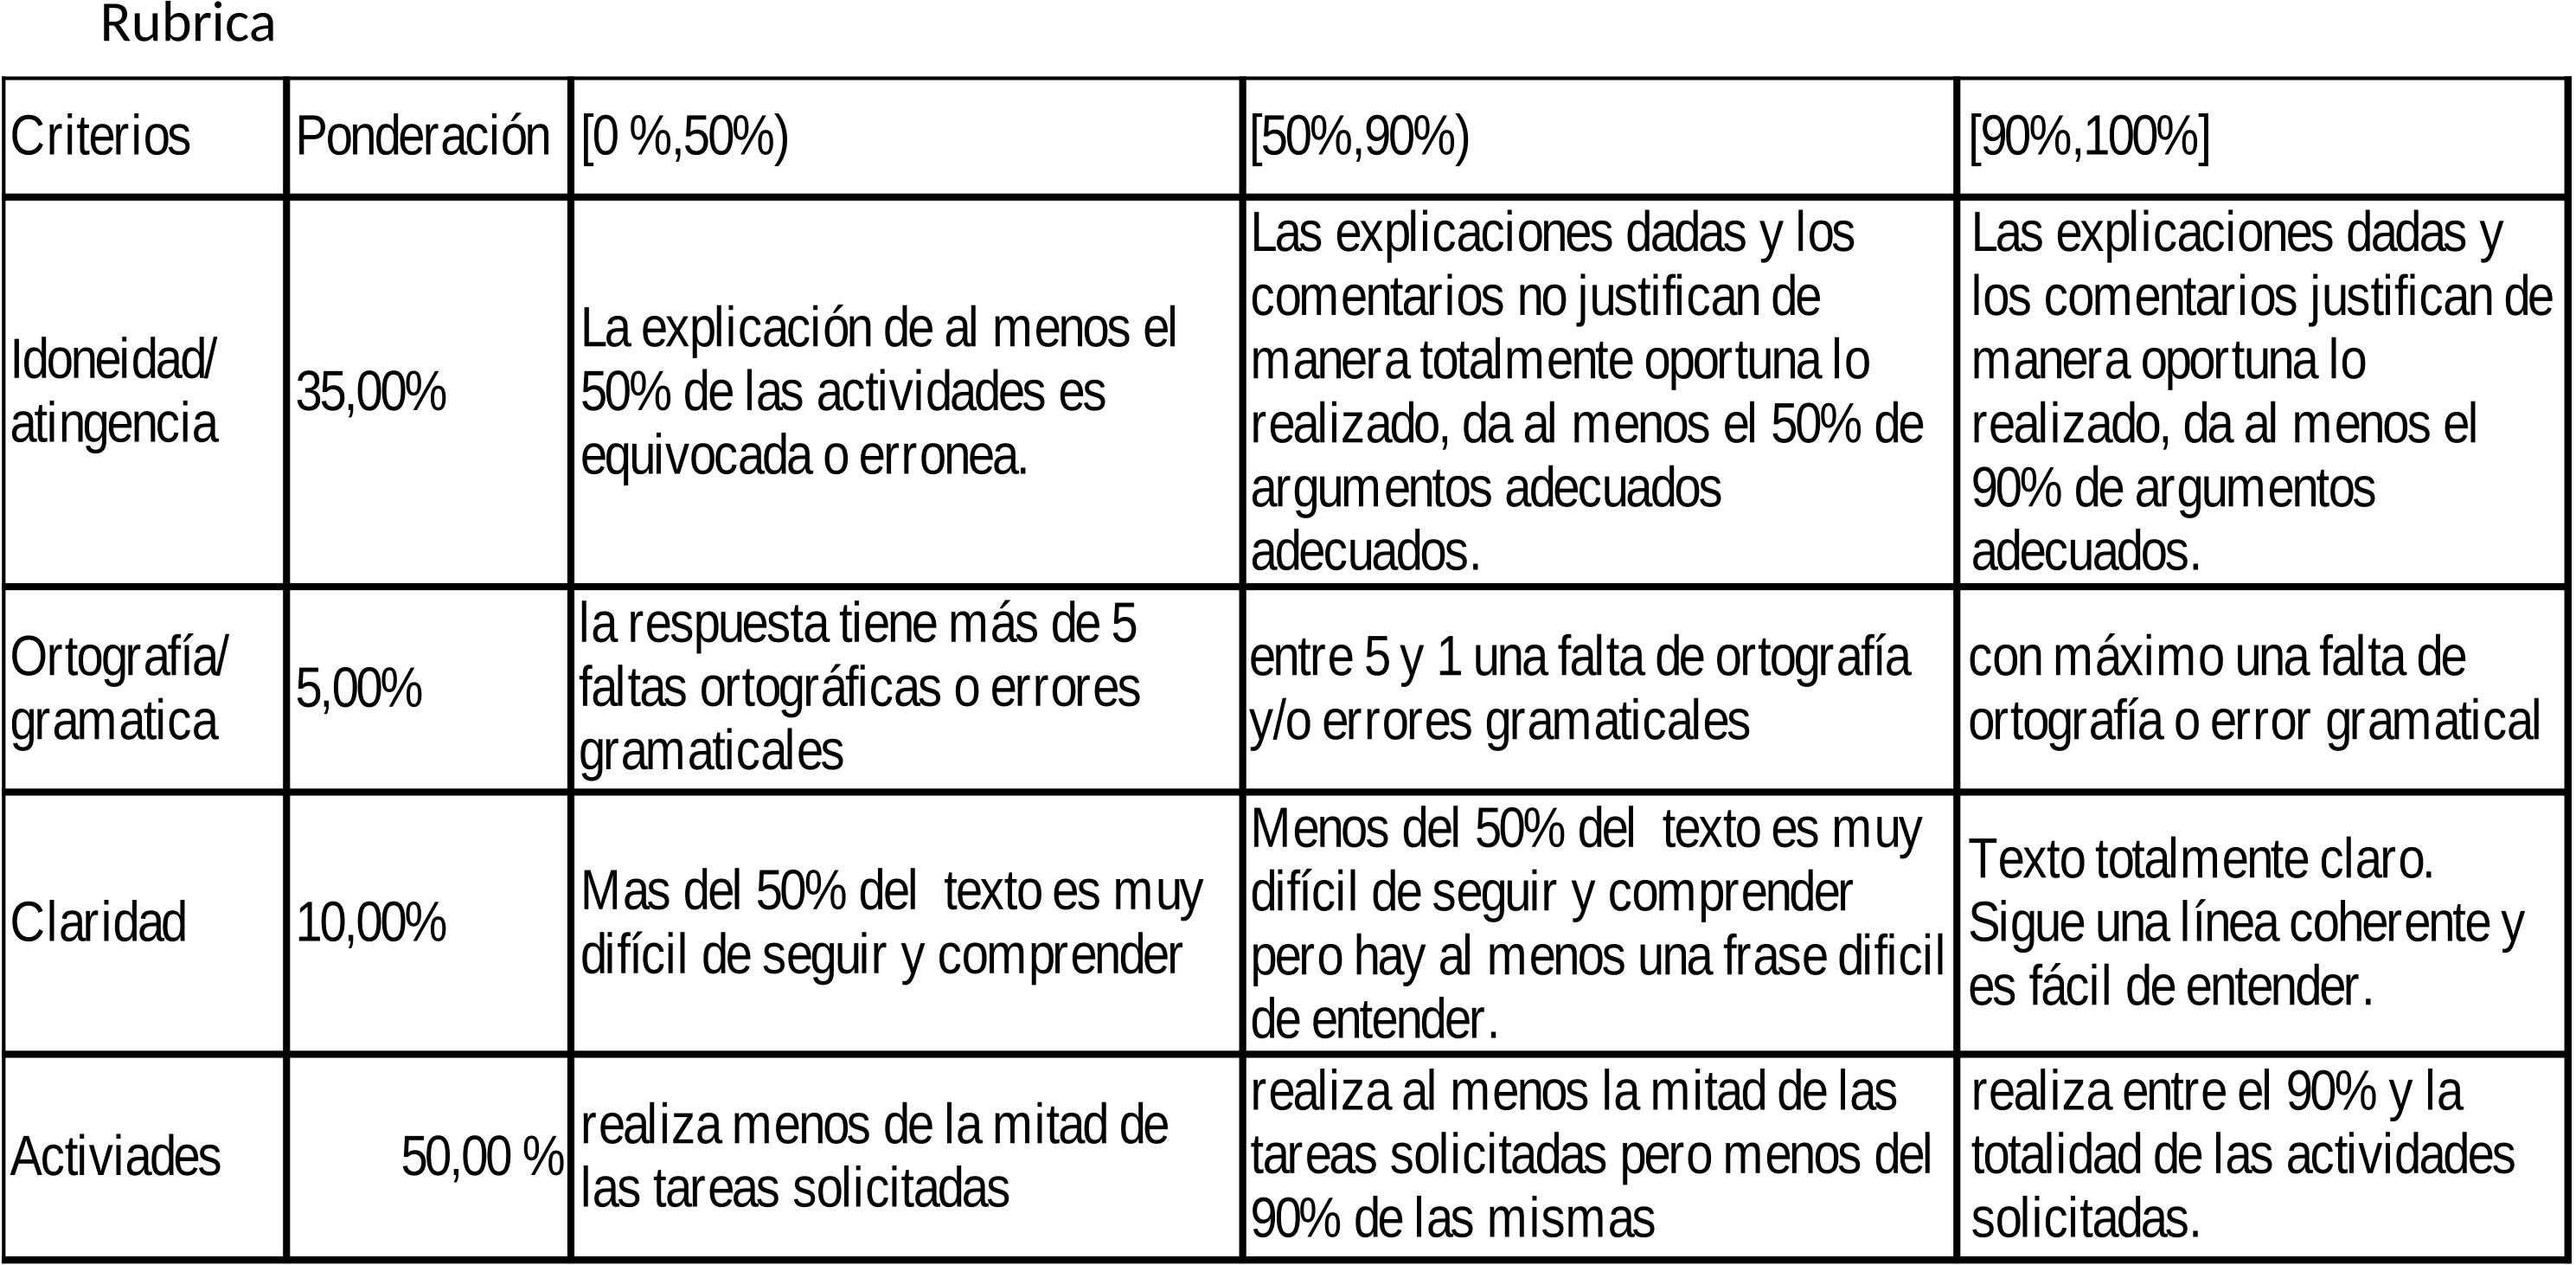


# Solemne 2: Determinación de hábitos de vida en base a información clínica

Usted ha sido recientemente contratado como científico de datos para una aseguradora de salud laboral. Esta empresa acaba de ser contratada por una constructora internacional especializada en la construcción de edificios muy altos, especialización en la que los hábitos de consumo de alcohol en los trabajadores suponen un peligro para la salud de los mismos. Por eso, en la aseguradora han diseñado un protocolo basado en el uso de información clínica de fácil acceso (chequeos médicos estandard y análisis de sangre) para en base a encuestas previas en su base de datos determinar que empleados consumen alcohol normalmente para poder ofrecerles acceso a programas de desintoxicación para reducir en lo posible las tasas de accidentes.

El archivo `habits_data_10e5.csv` contiene un dataset con los resultados de los chequeos médicos y análisis de sangre (**25 descriptores**) de **991346** individuos (100000 escogidos al azar para simplificar) de la base de datos de la aseguradora y  si estas personas consumen o no alcohol habitualmente.

*Dada esa información, construya un sistema para clasificar empleados en base a sus hábitos de consumo de alcohol a partir de los datos clínicos.*

Deben asegurarse de que sus sistema generaliza  y que han usado el mejor algoritmo clasificador con los mejores parámetros posibles para resolver esta tarea. Documenten el proceso y explique cada una de las decisiones que toma y que criterios las sustentan.


# Actividades

Aprovechando la gran cantidad de datos existentes en el dataset, construya un sistema que a través de  algoritmos de clasificación nos permita recomendar programas de desintoxicación/deshabituación a los empleados que habitualmente consumen alcohol.

El procedimiento a seguir debe ser el siguiente:

1. Utilicen al menos 3 algoritmos de los explicados en la unidad 2, busquen la mejor combinación de parametros usando los 25 descriptores del dataset que deben procesar de manera adecuada. Asegúrense de las capacidades de generalización de cada algoritmo con los mejores parámetros y comparen el desempeño usando las áreas bajo las curvas de cada uno de ellos.

2. Usen al menos un método para seleccionar los mejores 10 descriptores y compare el desempeño con las versiones de los mismos algoritmos del punto anterior con los parámetros óptimos ya determinados. Expliquen la diferencia en desempeños

3. Estudien ahora el efecto de normalizar (no estandarizar ni escalar) los datos. Los parámetros óptimos y el desempeño son distintos?, expliquen las diferencias observadas

Se entrega el jupyter notebook. Use celdas con texto para justificar y explicar cada paso.

Asegúrense de que la primera celda contiene el Nombre completo, email y rut de los miembros del equipo